### Assignment 02: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics




device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
BS = 128

train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=BS,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=BS,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [8]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [9]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(\
                                   nn.Linear(784, 256),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(256, 128),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(128, 64),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(64, 10),
                                   nn.LogSoftmax(dim = 1)
                                  )
        
    def forward(self, inp):       
        out = self.model(inp)

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
              ReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
       LogSoftmax-11                   [-1, 10]               0
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [11]:
TinyNeuralNetwork()

TinyNeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
    (10): LogSoftmax(dim=1)
  )
)

In [12]:
next(TinyNeuralNetwork().model.parameters()).is_cuda

False

In [13]:
TinyNeuralNetwork().to(device)

TinyNeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
    (10): LogSoftmax(dim=1)
  )
)

In [14]:
next(TinyNeuralNetwork().parameters()).is_cuda

False

Your experiments come here:

In [15]:
def train_model(model, optimizer, criterion, epochs):

    model = model.to(device)

    train_losses, test_losses, accuracy_list = [], [], []

    for e in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            # Flatten Fashion-MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            images = images.to(device)
            labels = labels.to(device)

            # Training pass
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        else:
            test_loss = 0
            accuracy = 0
            # Turn off gradients for validation, saves memory and computation
            with torch.no_grad():
              # Set the model to evaluation mode
              model.eval()

        # Validation pass
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1)

            images = images.to(device)
            labels = labels.to(device)

            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        accuracy_list.append(accuracy/len(test_loader))

        print("Epoch: {}/{}..".format(e+1, epochs),
              "Training loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Test loss: {:.3f}..".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
    return train_losses, test_losses, accuracy_list

In [16]:
# Define the epochs
epochs = 30
model = TinyNeuralNetwork().model
optimizer = optim.Adam(model.parameters(), lr = 0.002)
criterion = nn.NLLLoss()

train_losses1, test_losses1, accuracy_list1 = train_model(model, optimizer, criterion, epochs)

Epoch: 1/30.. Training loss: 0.638.. Test loss: 0.444.. Test Accuracy: 0.840
Epoch: 2/30.. Training loss: 0.429.. Test loss: 0.416.. Test Accuracy: 0.849
Epoch: 3/30.. Training loss: 0.391.. Test loss: 0.383.. Test Accuracy: 0.857
Epoch: 4/30.. Training loss: 0.369.. Test loss: 0.377.. Test Accuracy: 0.865
Epoch: 5/30.. Training loss: 0.356.. Test loss: 0.354.. Test Accuracy: 0.872
Epoch: 6/30.. Training loss: 0.344.. Test loss: 0.360.. Test Accuracy: 0.876
Epoch: 7/30.. Training loss: 0.332.. Test loss: 0.351.. Test Accuracy: 0.875
Epoch: 8/30.. Training loss: 0.325.. Test loss: 0.340.. Test Accuracy: 0.878
Epoch: 9/30.. Training loss: 0.314.. Test loss: 0.332.. Test Accuracy: 0.879
Epoch: 10/30.. Training loss: 0.309.. Test loss: 0.329.. Test Accuracy: 0.884
Epoch: 11/30.. Training loss: 0.305.. Test loss: 0.347.. Test Accuracy: 0.877
Epoch: 12/30.. Training loss: 0.301.. Test loss: 0.332.. Test Accuracy: 0.881
Epoch: 13/30.. Training loss: 0.293.. Test loss: 0.335.. Test Accuracy: 0

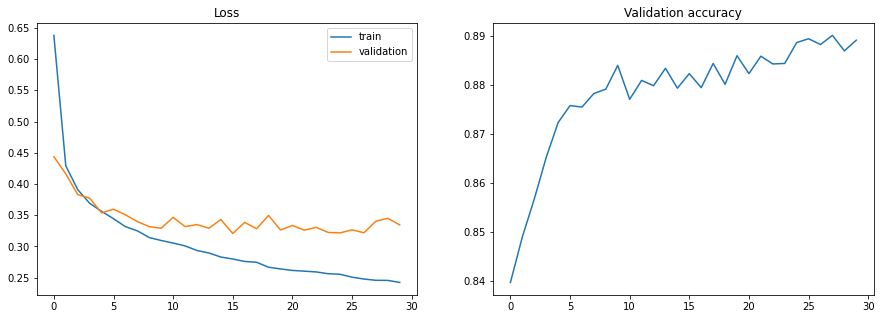

In [17]:
plot_train_process(train_losses1, test_losses1, accuracy_list1)

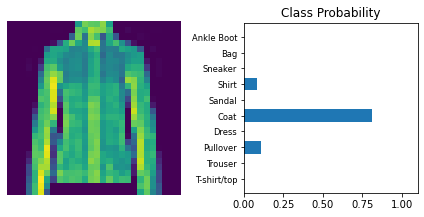

In [23]:
from random import randint

dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images[randint(0, 100)]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

img = img.to(device)
# Calculate the class probabilities (softmax) for img
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)

ps = ps.cpu()
img = img.cpu()

# Plot the image and probabilities
view_classify(img.cpu().resize_(1, 28, 28), ps, version='Fashion');

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [24]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 6219563008
free     : 2549612544
used     : 3669950464


In [28]:
def train_model_conv(model, optimizer, criterion, epochs):
    
    train_losses, test_losses, accuracy_list = [], [], []
    model.to(device)
    count = 0
    running_loss = 0
    labels_list = []
    
    for e in range(epochs):
        for images, labels in train_loader:
            # Transfering images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)
            train = Variable(images.view(-1, 1, 28, 28))
            labels = Variable(labels)

            # Forward pass 
            log_ps = model(train)
            loss = criterion(log_ps, labels)

            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()

            #Propagating the error backward
            loss.backward()

            # Optimizing the parameters
            optimizer.step()

            # Running loss
            running_loss += loss.item()

            count += 1

        else:
            test_loss = 0
            accuracy = 0
            # Turn off gradients for validation, saves memory and computation
            with torch.no_grad():
              # Set the model to evaluation mode
              model.eval()

        # Testing the net
        total = 0
        correct = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels_list.append(labels)

            test = Variable(images.view(-1, 1, 28, 28))

            log_ps = model(test)
            test_loss += criterion(log_ps, labels).item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        accuracy_list.append(accuracy/len(test_loader))

        print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(train_loader)),
          "Test loss: {:.3f}..".format(test_loss/len(test_loader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
    return train_losses, test_losses, accuracy_list

In [26]:
class FashionCNN2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [29]:
epochs2 = 30
model2 = FashionCNN2()
criterion2 = nn.CrossEntropyLoss()
learning_rate2 = 0.0001
optimizer2 = torch.optim.Adam(model.parameters(), lr=learning_rate2)

train_losses2, test_losses2, accuracy_list2 = train_model_conv(model2, optimizer2, criterion2, epochs2)

Epoch: 1/30.. Training loss: 2.304.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 2/30.. Training loss: 4.608.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 3/30.. Training loss: 6.912.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 4/30.. Training loss: 9.216.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 5/30.. Training loss: 11.519.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 6/30.. Training loss: 13.823.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 7/30.. Training loss: 16.127.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 8/30.. Training loss: 18.431.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 9/30.. Training loss: 20.735.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 10/30.. Training loss: 23.039.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 11/30.. Training loss: 25.343.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 12/30.. Training loss: 27.647.. Test loss: 2.304.. Test Accuracy: 0.049
Epoch: 13/30.. Training loss: 29.951.. Test loss: 2.304.. Test Ac

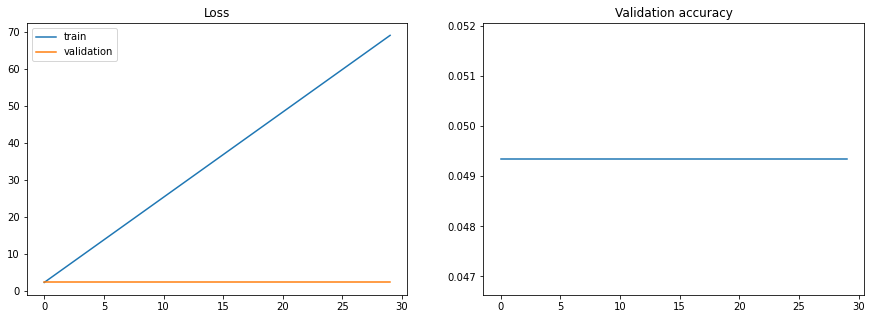

In [30]:
plot_train_process(train_losses2, test_losses2, accuracy_list2)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

In [ ]:
class FashionCNN3(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [ ]:
epochs3 = 30
model3 = FashionCNN3()
criterion3 = nn.CrossEntropyLoss()
learning_rate3 = 0.001
optimizer3 = torch.optim.Adam(model.parameters(), lr=learning_rate3)

train_losses3, test_losses3, accuracy_list3 = train_model_conv(model3, optimizer3, criterion3, epochs3)

In [ ]:
plot_train_process(train_losses3, test_losses3, accuracy_list3)

### Conclusions:
_Write down small report with your conclusions and your ideas._